# DNA Feature Importance for Expression

This notebook generates the figure showing the importance of each DNA feature for expression prediction, given by gain in model accuracy.

## Reproducibility Note
This notebook sets all relevant random seeds to ensure reproducible results:
- NumPy random seed for numerical operations
- Python random seed for general randomness
- XGBoost random_state for model training
- scikit-learn random_state for cross-validation splitting

In [1]:
# ! pip install xgboost


In [2]:
import sys
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
import random

# Add the repo's scripts directory to Python path for theme import
theme_path = os.path.abspath('../adaptyv/adaptyv_analyses/scripts/plotting_python')
if theme_path not in sys.path:
    sys.path.insert(0, theme_path)

# Import the Adaptyv theme from the repo
import blog_post_theme as adaptyv_theme

# Apply the theme
adaptyv_theme.set_adaptyv_matplotlib_theme()

# Get color palettes
palettes = adaptyv_theme.get_adaptyv_palettes()

# Set all random seeds for complete reproducibility
RANDOM_SEED = 42

# Python's built-in random
random.seed(RANDOM_SEED)

# NumPy
np.random.seed(RANDOM_SEED)

# Environment variable for some libraries that use it
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# XGBoost uses random_state parameter (set in model initialization)
# scikit-learn uses random_state parameter (set in StratifiedKFold)

print(f"All random seeds set to: {RANDOM_SEED}")
print("This ensures reproducible results across runs.")
print(f"Theme loaded from repo: {theme_path}")

All random seeds set to: 42
This ensures reproducible results across runs.
Theme loaded from repo: /Users/qamar/Downloads/adaptyv_nature_paper/egfr2024_post_competition/adaptyv/adaptyv_analyses/scripts/plotting_python


In [3]:
# Load the data from parquet file
df_data = pd.read_parquet('data/unioned_egfr_features.parquet')

# Filter rows with non-null dna_chisel_feature
df_filtered = df_data[df_data['dna_chisel_feature'].notna()].copy()

print(f"Number of rows with dna_chisel_feature: {len(df_filtered)}")
print(f"\nExpression distribution:")
print(df_filtered['expression'].value_counts())

Number of rows with dna_chisel_feature: 733

Expression distribution:
expression
high      469
medium    150
none       83
low        31
Name: count, dtype: int64


In [4]:
# Parse and flatten the DNA Chisel features JSON column
df_filtered['dna_chisel_feature_dict'] = df_filtered['dna_chisel_feature'].apply(json.loads)
features_df = pd.json_normalize(df_filtered['dna_chisel_feature_dict'])
features_df['expression'] = df_filtered['expression'].values

print(f"Number of DNA features extracted: {len(features_df.columns) - 1}")
print(f"\nSample of feature names:")
print(features_df.columns[:10].tolist())

Number of DNA features extracted: 36

Sample of feature names:
['at_skew', 'cai', 'codon_usage_entropy', 'gc_content', 'gc_content_std_dev', 'gc_skew', 'hairpin_score', 'homopolymer_run_length', 'in_frame_stop_codon_count', 'kozak_sequence_strength']


In [5]:
# Prepare data for binary classification
# 0 if expression is null or "none", 1 otherwise
features_df['is_expressed'] = features_df['expression'].apply(
    lambda x: 0 if pd.isnull(x) or str(x).lower() == 'none' else 1
)

print(f"Binary expression distribution:")
print(f"Not expressed (0): {(features_df['is_expressed'] == 0).sum()}")
print(f"Expressed (1): {(features_df['is_expressed'] == 1).sum()}")

# Define feature matrix X and target y
feature_cols = [
    col for col in features_df.columns 
    if col not in ['expression', 'is_expressed']
]
X = features_df[feature_cols].astype(float)
y_binary = features_df['is_expressed']

Binary expression distribution:
Not expressed (0): 83
Expressed (1): 650


In [6]:
# Set up 4-fold stratified cross-validation and train binary classifier
n_folds = 4
# IMPORTANT: random_state is set for reproducibility
skf_binary = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=RANDOM_SEED)

print(f"Performing {n_folds}-fold cross-validation for binary classification")
print(f"Using StratifiedKFold with random_state={RANDOM_SEED}")
print("Training XGBoost models...")

binary_metrics = {'auc': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
binary_feature_importances = []

for fold, (train_idx, test_idx) in enumerate(skf_binary.split(X, y_binary), 1):
    print(f"\nFold {fold}/{n_folds}")
    
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_binary.iloc[train_idx], y_binary.iloc[test_idx]
    
    # Train XGBoost model - matching original code exactly
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        max_depth=4,
        learning_rate=0.1,
        n_estimators=100,
        subsample=0.8,
        colsample_bytree=0.8,
        importance_type='gain',
        random_state=RANDOM_SEED,  # Ensures reproducible XGBoost training
    )
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    binary_metrics['auc'].append(roc_auc_score(y_test, y_pred_proba))
    binary_metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    binary_metrics['precision'].append(precision_score(y_test, y_pred))
    binary_metrics['recall'].append(recall_score(y_test, y_pred))
    binary_metrics['f1'].append(f1_score(y_test, y_pred))
    
    # Store feature importances
    importances = pd.Series(model.feature_importances_, index=X.columns)
    binary_feature_importances.append(importances)
    
    print(f"  AUC: {binary_metrics['auc'][-1]:.4f}")
    print(f"  Accuracy: {binary_metrics['accuracy'][-1]:.4f}")

Performing 4-fold cross-validation for binary classification
Using StratifiedKFold with random_state=42
Training XGBoost models...

Fold 1/4
  AUC: 0.7514
  Accuracy: 0.8804

Fold 2/4
  AUC: 0.7960
  Accuracy: 0.9016

Fold 3/4
  AUC: 0.8228
  Accuracy: 0.8907

Fold 4/4
  AUC: 0.7596
  Accuracy: 0.8962


In [7]:
# Calculate average feature importances across folds
binary_importance_df = pd.concat(binary_feature_importances, axis=1)
binary_avg_importance = binary_importance_df.mean(axis=1)
binary_std_importance = binary_importance_df.std(axis=1)

# Print model performance summary
print(f"\n=== Binary Classifier Performance (mean ± std across {n_folds} folds) ===")
for metric, values in binary_metrics.items():
    print(f"{metric.upper()}: {np.mean(values):.4f} ± {np.std(values):.4f}")


=== Binary Classifier Performance (mean ± std across 4 folds) ===
AUC: 0.7824 ± 0.0287
ACCURACY: 0.8922 ± 0.0078
PRECISION: 0.9074 ± 0.0104
RECALL: 0.9785 ± 0.0068
F1: 0.9415 ± 0.0040


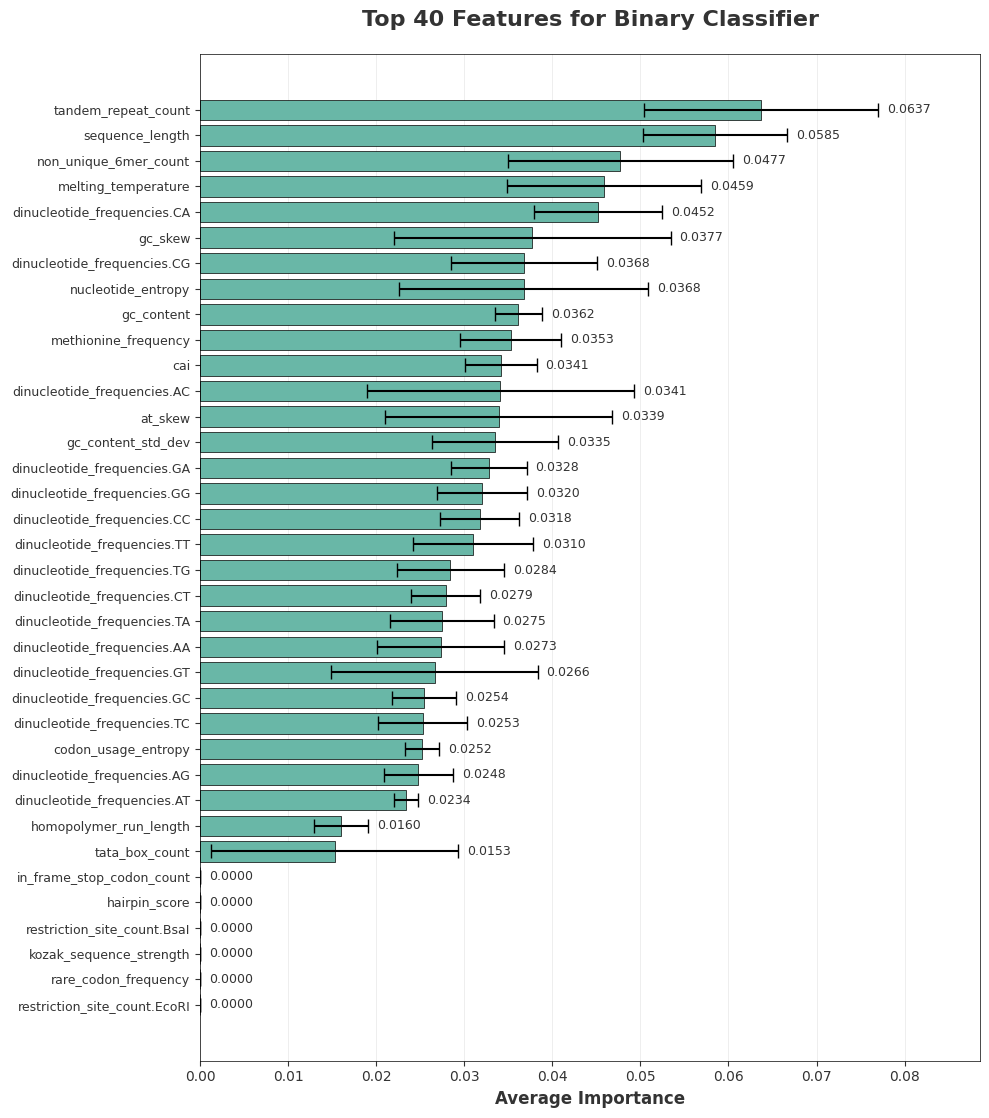

Importance of each DNA feature for expression, given by gain in model accuracy.


In [8]:
# Create figure: Feature importance plot with Adaptyv theme
n_top_features = 40

# Select and sort top features
top_features = binary_avg_importance.nlargest(n_top_features).sort_values(ascending=True)
top_std = binary_std_importance.loc[top_features.index]

# Create the plot with theme-appropriate size
fig, ax = plt.subplots(figsize=(10, 12))

# Use the expression "High" color from the repo's palette
expression_colors = palettes["expression"]
bar_color = expression_colors.get("High", "#69B7A7")

# Create horizontal bar chart with theme colors
bars = ax.barh(
    top_features.index,
    top_features.values,
    xerr=top_std.values,
    capsize=5,
    color=bar_color,
    edgecolor='black',
    linewidth=0.5
)

# Add value labels on the bars with theme text color
for bar, mean_val, std_val in zip(bars, top_features.values, top_std.values):
    # Position text slightly to the right of the error bar
    text_x = mean_val + std_val + 0.001
    ax.text(
        text_x,
        bar.get_y() + bar.get_height()/2,
        f'{mean_val:.4f}',
        va='center', 
        ha='left',
        fontsize=9,
        color='#333333'
    )

# Format the plot with theme styling
ax.set_xlabel('Average Importance', fontsize=12, fontweight='bold')
ax.set_title(f'Top {n_top_features} Features for Binary Classifier', 
            fontsize=16, fontweight='bold', pad=20)

# Add grid for better readability
ax.grid(True, alpha=0.3, linewidth=0.5, axis='x')
ax.set_axisbelow(True)

# Adjust x-axis limits for better visibility
ax.set_xlim(0, max(top_features.values + top_std.values) * 1.15)

# Style the y-axis labels (feature names)
ax.tick_params(axis='y', labelsize=9, colors='#333333')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

print('Importance of each DNA feature for expression, given by gain in model accuracy.')


## Top Features Summary

Display the top features with their importance values:

In [9]:
# Print top features with their importance values
print(f"\nTop {n_top_features} Features for Binary Classifier:")
print("="*60)
for i, (feature, mean_val) in enumerate(top_features.items(), 1):
    std_val = top_std[feature]
    print(f"{i:2d}. {feature:40s}: {mean_val:.4f} ± {std_val:.4f}")


Top 40 Features for Binary Classifier:
 1. restriction_site_count.EcoRI            : 0.0000 ± 0.0000
 2. rare_codon_frequency                    : 0.0000 ± 0.0000
 3. kozak_sequence_strength                 : 0.0000 ± 0.0000
 4. restriction_site_count.BsaI             : 0.0000 ± 0.0000
 5. hairpin_score                           : 0.0000 ± 0.0000
 6. in_frame_stop_codon_count               : 0.0000 ± 0.0000
 7. tata_box_count                          : 0.0153 ± 0.0140
 8. homopolymer_run_length                  : 0.0160 ± 0.0031
 9. dinucleotide_frequencies.AT             : 0.0234 ± 0.0014
10. dinucleotide_frequencies.AG             : 0.0248 ± 0.0040
11. codon_usage_entropy                     : 0.0252 ± 0.0019
12. dinucleotide_frequencies.TC             : 0.0253 ± 0.0051
13. dinucleotide_frequencies.GC             : 0.0254 ± 0.0036
14. dinucleotide_frequencies.GT             : 0.0266 ± 0.0117
15. dinucleotide_frequencies.AA             : 0.0273 ± 0.0072
16. dinucleotide_frequencies.T

## Save the figure

Uncomment the following cell to save the figure as a high-resolution image:

Figure saved to plots/dna_feature_importance.png


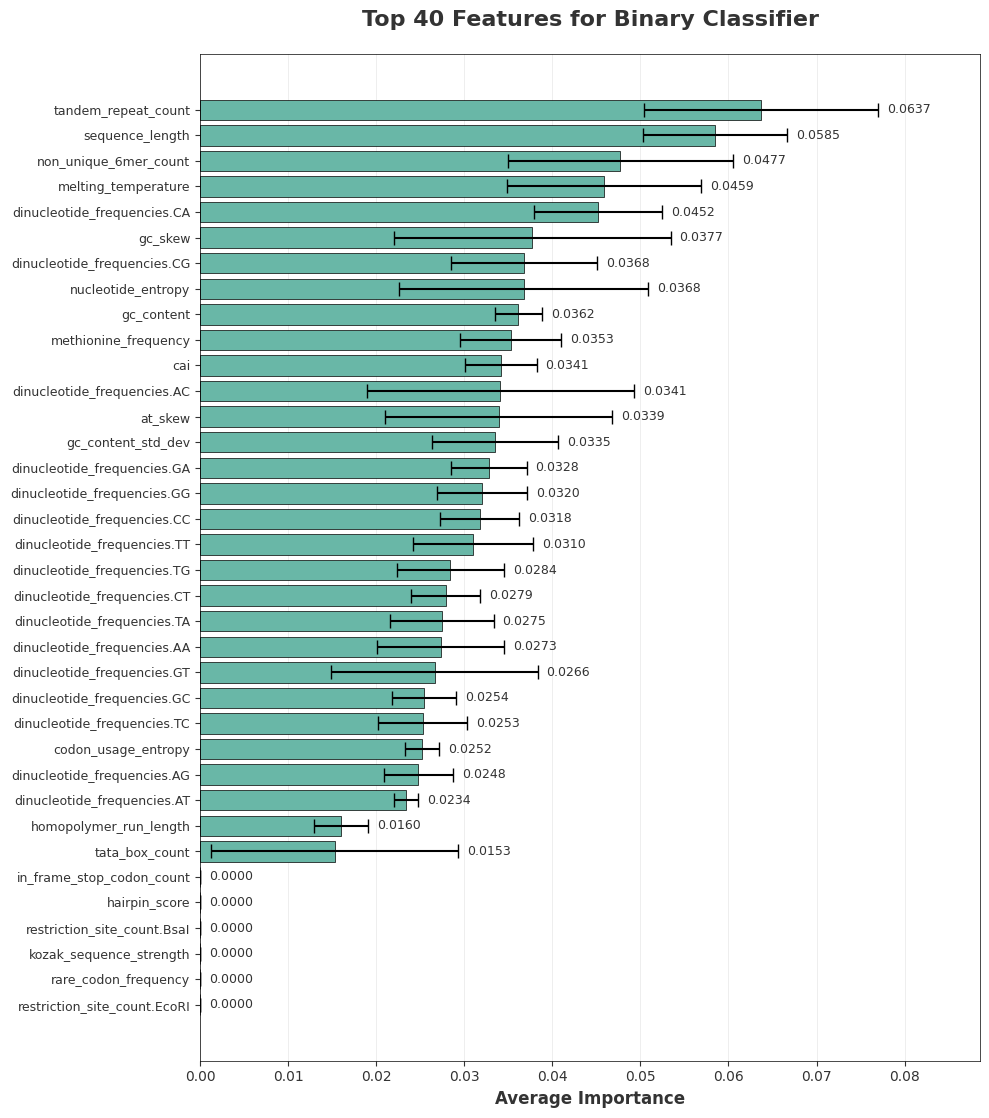

In [10]:
# Save the figure with repo's theme settings
output_dir = 'plots'
os.makedirs(output_dir, exist_ok=True)

# Recreate the plot for saving
fig, ax = plt.subplots(figsize=(10, 12))

# Use the expression "High" color from the repo's palette
expression_colors = palettes["expression"]
bar_color = expression_colors.get("High", "#69B7A7")

# Create horizontal bar chart
bars = ax.barh(top_features.index, top_features.values, xerr=top_std.values,
               capsize=5, color=bar_color, edgecolor='black', linewidth=0.5)

# Add value labels on the bars
for bar, mean_val, std_val in zip(bars, top_features.values, top_std.values):
    text_x = mean_val + std_val + 0.001
    ax.text(text_x, bar.get_y() + bar.get_height()/2, f'{mean_val:.4f}',
            va='center', ha='left', fontsize=9, color='#333333')

# Format the plot
ax.set_xlabel('Average Importance', fontsize=12, fontweight='bold')
ax.set_title(f'Top {n_top_features} Features for Binary Classifier', 
            fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, linewidth=0.5, axis='x')
ax.set_axisbelow(True)
ax.set_xlim(0, max(top_features.values + top_std.values) * 1.15)
ax.tick_params(axis='y', labelsize=9, colors='#333333')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])

# Save the figure
output_path = os.path.join(output_dir, 'dna_feature_importance.png')
fig.savefig(output_path, dpi=300, bbox_inches='tight', 
           facecolor='white', edgecolor='none')
print(f"Figure saved to {output_path}")